## Sentiment Classification - Movie Review Dataset

CNNs and RNNs for Sentiment Analysis

In [1]:
from IPython.display import HTML, display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = [["CNNs","RNNs"],
        
        ["Used for mainly extracting spatial fearures" ,"Focuses on the temporal or sequence data"],
        
        ["CNN extracts the most informative ngrams for the relation and only considers their resulting activations","RNN computes a weighted combination of all words in the sentence"],
        
        ["Works better with Attention-based models and can also model long context dependency","Loses context during sequence to sequence structures"]]
        
      
display(HTML(
   '<table><tr><center>{}</center></tr></table>'.format(
       '</tr><tr>'.join(
           '<td><center>{}</center></td>'.format('<center></td><td></center>'.join(str(_) for _ in row)) for row in data)
       )
))

CNNs,RNNs
Used for mainly extracting spatial fearures,Focuses on the temporal or sequence data
CNN extracts the most informative ngrams for the relation and only considers their resulting activations,RNN computes a weighted combination of all words in the sentence
Works better with Attention-based models and can also model long context dependency,Loses context during sequence to sequence structures


In [3]:
# importing required libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os
from os import listdir
import string
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models,layers

Using TensorFlow backend.


The data used is IMDB review data. It has two classes positive and negative.

In [7]:
train_labels = []
train_texts = []

test_labels = []
test_texts = []

train_dir = 'aclImdb/train'
# appending all the reviews with their respective labels for training data
for label_type in ['pos','neg']:
    dir_name = os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname), encoding="utf8")
            train_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                train_labels.append(0)
            else:
                train_labels.append(1)


In [8]:

test_dir = 'aclImdb/test'
# appending all the reviews with their respective labels for testing data
for label_type in ['pos','neg']:
    dir_name = os.path.join(test_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name,fname), encoding="utf8")
            test_texts.append(f.read())
            f.close()
            if label_type == 'neg':
                test_labels.append(0)
            else:
                test_labels.append(1)


In [9]:
# converting into a dataframe
texts_df = pd.DataFrame({'texts': train_texts,
                        'labels':train_labels})
texts_df.head()

,texts,labels
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [10]:
import nltk
from nltk.corpus import stopwords

In [11]:
word_counts = texts_df['texts'].apply(lambda x: len(x.split()))

In [12]:
# forming the whole dictionary of all the words in the reviews
corpus = texts_df['texts'].apply(lambda x: x.split()).tolist()

In [13]:
# removing the common stop words and vectorizing the words
count_vect = CountVectorizer(stop_words=stopwords.words('english'))
bag_of_words = count_vect.fit_transform(texts_df['texts'])


In [14]:
# checking the frequency of the words
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [15]:
# observing the high frequency words
top_30_words = words_freq[:30]
top_word_list = []
top_count_list = []
for item in top_30_words:
    top_word_list.append(item[0])
    top_count_list.append(item[1])

In [16]:
print(top_count_list[0:6])

[101871, 44047, 40159, 26795, 20281, 15147]


In [17]:
print(top_word_list[0:6])

['br', 'movie', 'film', 'one', 'like', 'good']


In [18]:
# adding the most occuring words as stop words
my_stop_words = stopwords.words('english')+(top_word_list[0:6])

In [19]:
# vectorizing the words again 
count_vect = CountVectorizer(stop_words=my_stop_words)
bag_of_words = count_vect.fit_transform(texts_df['texts'])

In [20]:
MAX_LENGTH = 500
MAX_WORDS = 20000
EMBENDING_DIM = 100

In [21]:
# forming tokens of the train data
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

In [22]:
print('number of tokens: ', len(tokenizer.word_counts))

number of tokens:  88582


In [23]:
# padding words with a smaller length
train_data = pad_sequences(sequences,maxlen=MAX_LENGTH)
labels = np.array(train_labels)

In [24]:
# train val split
X_train, X_val, y_train, y_val = train_test_split(train_data,labels,test_size=0.2,random_state=42)

In [25]:
# loading the glove embeddings - the words and their corresponding vectors
glove_dir = "glove.6B.100d.txt"
embedding_index = {}
f = open(glove_dir, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    embedding_index[word] = vector
f.close()

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [26]:
embedding_index['sit'][:10]

array([-0.42142,  0.53956, -0.26822, -0.24366, -0.62731,  0.89743,
       -0.57398,  0.92691, -0.37078, -0.72003], dtype=float32)

In [27]:
embedding_matrix = np.zeros((MAX_WORDS,EMBENDING_DIM))

In [28]:
# creating an embedding matrix for the words present in the vocabulary
for word, i in (tokenizer.word_index).items():
    if i < MAX_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [29]:
# converting matrix into dataframe
#embedding_df = pd.DataFrame(embedding_matrix)

In [30]:
# importing libraries for creating a model
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

In [31]:
# defining a LSTM model
model = models.Sequential()
model.add(layers.Embedding(MAX_WORDS,EMBENDING_DIM, input_length=MAX_LENGTH))
model.add(layers.LSTM(32))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,017,057
Trainable params: 2,017,057
Non-trainable params: 0
_________________________________________________________________


In [32]:
# setting the weights if the embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [33]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])

model.save_weights('pre_trained_glove_model.h5')

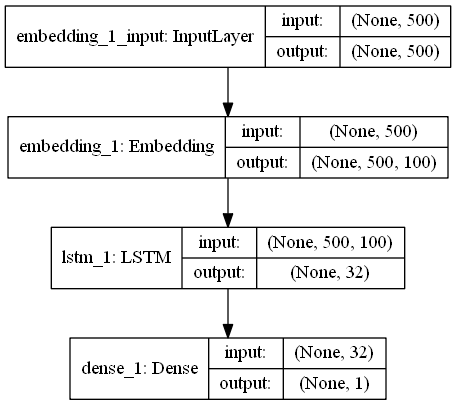

In [34]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='sentiment_analysis_imdb.png')

In [35]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.5794 - acc: 0.6959 - val_loss: 0.4901 - val_acc: 0.7664
Epoch 2/10
20000/20000 [==============================] - 81s 4ms/step - loss: 0.4543 - acc: 0.7936 - val_loss: 0.4228 - val_acc: 0.8002
Epoch 3/10
20000/20000 [==============================] - 91s 5ms/step - loss: 0.3941 - acc: 0.8279 - val_loss: 0.4264 - val_acc: 0.7944
Epoch 4/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.3521 - acc: 0.8505 - val_loss: 0.3492 - val_acc: 0.8570
Epoch 5/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.3265 - acc: 0.8647 - val_loss: 0.3171 - val_acc: 0.8722
Epoch 6/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.3068 - acc: 0.8718 - val_loss: 0.3115 - val_acc: 0.8754
Epoch 7/10
20000/20000 [==============================] - 100s 5ms/step - loss: 0.2887 - acc: 0.8839 - val_loss: 0.3274 - val_a

In [36]:
# creating tokens of the test data and padding all inputs to a common length
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences,maxlen=MAX_LENGTH)
test_labels = np.array(test_labels)

In [37]:
# predicting the test data
predictions = model.predict(test_data)

In [38]:
len(predictions)

25000

In [39]:
pred_proba = model.predict_proba(test_data)

In [40]:
# generating the labels of the predictions - positive or negative class
pred_labels  = (predictions>0.5)
pred_labels[0]

array([ True])

In [41]:
import seaborn as sns

Text(15.380000000000003, 0.5, 'predicted label')

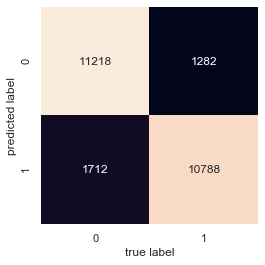

In [42]:
# creating a confusion matrix
mat = confusion_matrix(pred_labels, test_labels)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')